<a href="https://colab.research.google.com/github/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/L09/LQR_different_solutions_SOLUTIONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ♻ Deterministic LQR - batch and recursive solutions

This exercise explores the control of a CNC (Computer Numerical Control) machine head using the framework of Linear Quadratic Regulation (LQR). The objective is to move the CNC head from an initial position to the origin (0, 0) while minimizing acceleration, ensuring a smooth and efficient motion. This is achieved by finding the optimal sequence of control inputs (e.g., forces or accelerations) that guide the head towards the target. The LQR problem is formulated as:

<table>
<tr>
<td>
<p>
\begin{aligned}
\min_{U} \
 &s_T^{\top} P s_T + \sum_{t=0}^{T-1}\left[s_t^{\top} Q s_t+u_t^{\top} R u_t\right]\\
&s.t.: \quad s_{t+1}=A s_t+B u_t \quad\quad \ \it{state \ equation} \\
& \qquad \qquad s_{t=0} = s_0 \qquad  \qquad \it{initial \ condition}
\end{aligned}
</p>
</td>
<td>
<img src="https://github.com/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/L09/figs/LQR_3.png?raw=true" width="200">
</td>
</tr>
</table>



### States and Dynamic matrices:
The state $s \in \mathbb{R}^2 = [p, v]$ encodes the position (linear, with respect to a reference) and the velocity of the CNC's head. What are $A$ and $B$ in this case?
<center>
<table>
<tr>
<th> Equations of motion </th>
<th> $A$, links the previous state with the following one </th>
<th> $B$ links inputs with state </th>
</tr>

<tr>
<td>
$$
\begin{aligned}
p_{t+1} &= p_t + v_t dt + 0.5 a_t dt^2 \\
v_{t+1} &= v_t + a_t dt
\end{aligned}
$$
</td>
<td>
$$A = \begin{bmatrix} 1 & dt \\ 0 & 1 \end{bmatrix}$$
</td>
<td>
$$B = \begin{bmatrix} 0.5 dt^2 \\ dt \end{bmatrix}$$
</td>
</tr>


</table>
</center>

### Compared approaches

**Batch Approach**: This method formulates the entire control problem as a single, large quadratic optimization problem. By considering the system dynamics and cost function over the entire control horizon, it directly solves for the optimal sequence of control inputs.
<table>
<tr>
<td>
<p>
$$U^* = (\Lambda_u^{\top}\bar{Q}\Lambda_u  + \bar{R})^{-1} \Lambda_u^T\bar{Q}\Lambda_ss_0
\qquad
\begin{aligned}&\bar{Q}=\operatorname{blockdiag}(Q, Q, \ldots, Q, P),  \\
&\bar{R}=\operatorname{blockdiag}(R, R, \ldots, R)
\end{aligned}
$$
</p>
</td>
<td>
<img src="https://github.com/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/L09/figs/LQR_2.png?raw=true" width="200">
</td>
</tr>
</table>

**Recursive Approach** (Dynamic Programming): This method utilizes the principle of dynamic programming and the backward Riccati recursion. It starts from the final time step and works backward, calculating the optimal control gains and cost-to-go matrices for each time step. Once these gains are determined, the control law is applied forward in time to generate the optimal state and input trajectories. This approach breaks down the problem into smaller subproblems, solving them sequentially.
<table>
<tr>
<td>
<p>
$$\begin{aligned}
K_t &= (R + B^{\top}P_tB)^{-1}B^{\top}P_tA\\
u_t^* &= -K_t s_t\\
P_{t-1} &= Q + A^{\top}P_tA -K_{t}^{\top}B^{\top}P_tA
\end{aligned}
\qquad\qquad\qquad\qquad\qquad\qquad\quad
$$
</p>
</td>
<td>
<img src="https://github.com/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/L09/figs/LQR_2.png?raw=true" width="200">
</td>
</tr>
</table>

**Miopic solution** This is the solution obtained optimizing the one step cost to go: $ \min_{u_0} s_1^{\top} Q s_1+u_0^{\top} R u_0$. This can be solved plugging in the dynamic equation to find the next step state and setting the gradient of the loss to 0:
<table>
<tr>
<td>
<p>
$$\begin{align}
&\nabla_{u_0}  [(As_0 + B u_0)^{\top} Q (As_0 + B u_0)+u_0^{\top} R u_0] = 0\\
& u_0^* = -2(R + B ^{\top} Q  B)^{-1} B^{\top} Q A s_0 = K_{mio} s_0\\
& u_1^* = K_{mio} s_1 = K_{mio} (A s_0 + B u_0^*)\\
&\dots
\end{align}
\qquad\qquad\qquad\quad\quad
$$
</p>
</td>
<td>
<img src="https://github.com/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/L09/figs/LQR_1.png?raw=true" width="200">
</td>
</tr>
</table>



In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Problem dimensions
n = 2  # state dimension
m = 1  # input dimension
T = 100 # horizon length

# System matrices: let's consider a simple double integrator
# x = [position; velocity]
# discretized dynamics:
# x_{t+1} = A x_t + B u_t
dt = 0.1
A = np.array([[1, dt],
              [0,  1]])
B = np.array([[0.5 * dt**2],
              [dt]])

# Cost matrices
Q = np.diag([1.0, 0.1])   # State cost
R = np.array([[0.01]])   # Input cost
S = Q                     # Terminal cost (just reuse Q for simplicity)

# Initial state
x0 = np.array([5.0, 0.0])  # start away from origin with zero velocity


### Batch solution
There's a closed form solution for the batch LQR:
$$U^* = (\Lambda_u^{\top}\bar{Q}\Lambda_u  + \bar{R})^{-1} \Lambda_u^T\bar{Q}\Lambda_ss_0
\qquad
\begin{aligned}&\bar{Q}=\operatorname{blockdiag}(Q, Q, \ldots, Q, P),  \\
&\bar{R}=\operatorname{blockdiag}(R, R, \ldots, R)
\end{aligned}
$$
the difficult part is to build the matrices $\bar{Q}$, $\bar{R}$, $\Lambda_u$, $\Lambda_s$. For this we can use the `np.kron` function. In the following ther's a minimal example showing how this command works:  

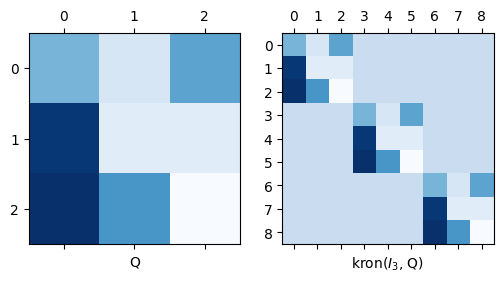

In [4]:
Q_example = np.random.randn(3, 3)
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].matshow(Q_example, cmap='Blues'); ax[0].set_xlabel('Q');
ax[1].matshow(np.kron(np.eye(3), Q_example), cmap='Blues');ax[1].set_xlabel(r'kron($I_3$, Q)');


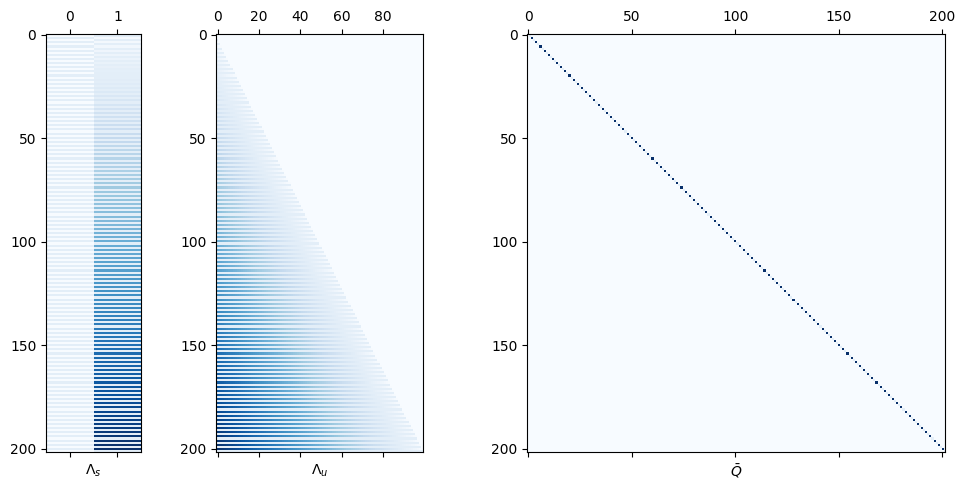

In [42]:

# -----------------------------------------------------------------------------
# Batch Approach
# -----------------------------------------------------------------------------
def lqr_batch(A, B, Q, R, S, T, x0, do_plots=False):
    """
    Solve finite-horizon LQR by forming a large quadratic problem:

    We have cost:
    J = x_T^T S x_T + sum_{t=0}^{T-1} (x_t^T Q x_t + u_t^T R u_t)

    Subject to:
    x_{t+1} = A x_t + B u_t, for t=0,...,T-1
    with x_0 given.

    We can eliminate the states and write J in terms of U = [u_0; ...; u_{T-1}].
    Then differentiate and solve for U.
    """

    n, m = A.shape[0], B.shape[1]

    # Compute powers of A and stack them
    Lambda_s = np.vstack([np.linalg.matrix_power(A, i) for i in range(T + 1)])

    # Build Big_B using block lower triangular structure
    Lambda_u = np.zeros(((T+1)*n, T*m))
    for t in range(1, T+1):
        for tau in range(t):
            A_power = np.linalg.matrix_power(A, t - 1 - tau)
            Lambda_u[t*n:(t+1)*n, tau*m:(tau+1)*m] = A_power @ B

    # Build Q_all: block diagonal with Q (T times) + S at terminal
    Q_all = np.kron(np.eye(T), Q)
    Q_all = np.block([
        [Q_all, np.zeros((T*n, n))],
        [np.zeros((n, T*n)), S]
    ])

    # Build R_all: block diagonal with R repeated T times
    R_all = np.kron(np.eye(T), R)

    # Compute cost terms
    H = Lambda_u.T @ Q_all @ Lambda_u + R_all
    f = Lambda_u.T @ Q_all @ Lambda_s @ x0

    # Solve for optimal U
    U_opt = -np.linalg.solve(H, f).reshape(T, m)

    # Recover state trajectory
    X_opt = (Lambda_s @ x0 + Lambda_u @ U_opt.reshape(T*m, order='F')).reshape(T+1, n).T
    u_opt = U_opt.T
    if do_plots:
      fig, ax = plt.subplots(1, 3, figsize=(10, 5), width_ratios=[1, 5, 5], layout='tight')
      ax[0].matshow(Lambda_s, cmap='Blues',aspect='auto'); ax[0].set_xlabel(r'$\Lambda_s$');
      ax[1].matshow(Lambda_u, cmap='Blues'); ax[1].set_xlabel(r'$\Lambda_u$');
      ax[2].matshow(Q_all, cmap='Blues'); ax[2].set_xlabel(r'$\bar{Q}$');


    return X_opt, u_opt

X_batch, U_batch = lqr_batch(A, B, Q, R, S, T, x0, do_plots=True)



### 🥋 **Your turn! Dynamic programming solution**
The dynamic programmning solution starts from obtaining the optimal solution at t=T-1 and obtains the previous ones by backward induction. Starting from $P_t = P$:
\begin{aligned}
K_t &= (R + B^{\top}P_tB)^{-1}B^{\top}P_tA\\
u_t^* &= -K_t s_t\\
P_{t-1} &= Q + A^{\top}P_tA -K_{t}^{\top}B^{\top}P_tA
\end{aligned}
Try to define the lqr_dp in the following block.  
**YOU CAN CHECK YOUR SOLUTION AGAINST THE BATCH APPROACH USING THE PLOTTING BLOCK FOLLOWING THIS ONE**

In [6]:

# -----------------------------------------------------------------------------
# Dynamic Programming (Backward Riccati)
# -----------------------------------------------------------------------------
def lqr_dp(A, B, Q, R, S, T, x0):
    """
    Solve finite-horizon LQR via backward recursion.
    Returns K_t (feedback gains), P_t (cost-to-go matrices), and the optimal inputs u_t.
    """
    n = A.shape[0]
    m = B.shape[1]

    # Arrays to store solutions
    P = [None]*(T+1)
    K = [None]*T

    # Terminal condition
    P[T] = S

    # Backward Riccati recursion
    for t in reversed(range(T)):
        Pt1 = P[t+1]
        # Compute feedback gain K_t = -(R + B^T P_{t+1} B)^{-1} (B^T P_{t+1} A)
        BtPt1B = B.T @ Pt1 @ B
        BtPt1A = B.T @ Pt1 @ A
        inv_term = np.linalg.inv(R + BtPt1B)
        K[t] = inv_term @ BtPt1A

        # Update P_t
        P[t] = Q + A.T @ Pt1 @ A - K[t].T @ B.T @ Pt1  @ A

    # Now apply the control law forward to get optimal state and input trajectories
    x = np.zeros((n, T+1))
    u = np.zeros((m, T))
    x[:,0] = x0
    for t in range(T):
        u[:,t] = -K[t] @ x[:,t]
        x[:,t+1] = A @ x[:,t] + B @ u[:,t]

    return K, P, x, u

K_dp, P_dp, x_dp, u_dp = lqr_dp(A, B, Q, R, S, T, x0)

In [7]:
import plotly.graph_objects as go

# -----------------------------------------------------------------------------
# Compare Results
# -----------------------------------------------------------------------------

print("DP solution u_0:", u_dp[:,0])
print("Batch solution u_0:", U_batch[:,0])

print("DP final state:", x_dp[:,-1])
print("Batch final state:", X_batch[:,-1])

# Both methods should yield the same optimal solution up to numerical precision differences.
# DP method computes K_t and then applies forward. The batch method solves all at once.

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(T+1), y=x_dp[0,:], mode='lines', name='DP position'))
fig.add_trace(go.Scatter(x=np.arange(T+1), y=X_batch[0,:], mode='markers', name='Batch position'))
fig.add_trace(go.Scatter(x=np.arange(T+1), y=x_dp[1,:], mode='lines', name='DP velocity'))
fig.add_trace(go.Scatter(x=np.arange(T+1), y=X_batch[1,:], mode='markers', name='Batch velocity'))
fig.show()

DP solution u_0: [-38.06478986]
Batch solution u_0: [-38.06478986]
DP final state: [-2.00247042e-11 -1.93335054e-11]
Batch final state: [-2.00461869e-11 -1.93360883e-11]


### Miopic solution
What if we are going to optimize just the next action? In this case we got the formula
$$u_0^* = -2(R + B ^{\top} Q  B)^{-1} B^{\top} Q A s_0$$
The following cell implements this srategy, and compare it with the other two. **What do you notice?**


In [8]:
def lqr_miopic(A, B, Q, R, S, T, x0):
    """
    Solve finite-horizon LQR via backward recursion.
    Returns K_t (feedback gains), P_t (cost-to-go matrices), and the optimal inputs u_t.
    """
    n = A.shape[0]
    m = B.shape[1]

    # Arrays to store solutions
    P = [None]*(T+1)


    inv_term = np.linalg.inv(R + B.T @ Q @ B)
    K_mio = -2 * inv_term @ B.T @ Q @ A


    # Now apply the control law forward to get optimal state and input trajectories
    x = np.zeros((n, T+1))
    u = np.zeros((m, T))
    x[:,0] = x0
    for t in range(T):
        u[:,t] = K_mio @ x[:,t]
        x[:,t+1] = A @ x[:,t] + B @ u[:,t]

    return K_mio, x, u

K_mio, x_miopic, u_miopic = lqr_miopic(A, B, Q, R, S, T, x0)


In [9]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(T+1), y=x_dp[0,:], mode='lines', name='DP position'))
fig.add_trace(go.Scatter(x=np.arange(T+1), y=X_batch[0,:], mode='markers', name='Batch position'))
fig.add_trace(go.Scatter(x=np.arange(T+1), y=x_miopic[0,:], mode='markers', name='Miopic position'))
fig.add_trace(go.Scatter(x=np.arange(T+1), y=x_dp[1,:], mode='lines', name='DP velocity'))
fig.add_trace(go.Scatter(x=np.arange(T+1), y=X_batch[1,:], mode='markers', name='Batch velocity'))
fig.add_trace(go.Scatter(x=np.arange(T+1), y=x_miopic[1,:], mode='markers', name='Miopic velocity'))
fig.show()


# Implicitly handling stochasticity
Let's now imagine a stochastic acceleration $\color{red}{f(w)}$ is imposed on the CNC head, where $w$ comes from an unknown distribution $\color{red}{\mathcal{W}}$. This could be for example a negative acceleration resulting from the non-uniformity of the material density.


\begin{aligned}
\min_{U} \
 &s_T^{\top} P s_T + \sum_{t=0}^{T-1}\left[s_t^{\top} Q s_t+u_t^{\top} R u_t\right]\\
&s.t.: \quad s_{t+1}=A s_t+B (u_t + \color{red}{f(w_t
)}) \quad\quad \ \color{red}{w_t \sim \mathcal{W}} \\
& \qquad \qquad s_{t=0} = s_0
\end{aligned}




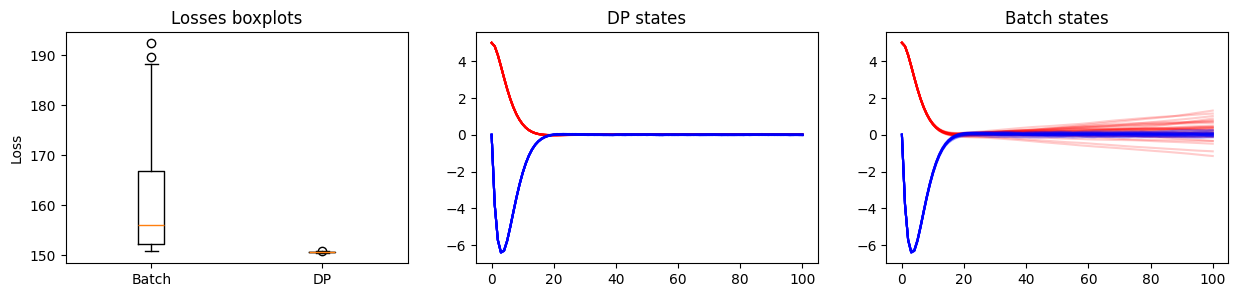

In [10]:
draw_f = lambda n: 1e-1*np.random.randn(n) # nominal density + stochastic variation

# Check the robustness against stochastic variation of desity for the open loop batch approach and open loop recursive approach

n_tests = 30 # number of tests
losses_batch = np.zeros(n_tests)
losses_dp = np.zeros(n_tests)
losses_miopic = np.zeros(n_tests)
xs_dp = []
xs_batch = []
for k in range(n_tests):
  f_w = draw_f(T)
  x_batch, u_batch = lqr_batch(A, B, Q, R, S, T, x0)
  Kt, Pt, x_dp, u_dp = lqr_dp(A, B, Q, R, S, T, x0)
  Kmio, x_miopic, u_miopic = lqr_miopic(A, B, Q, R, S, T, x0)

  # obtain the state under stochastic force f_w
  x_batch_w = np.zeros((n, T+1))
  x_batch_w[:,0] = x0
  x_dp_w = np.zeros((n, T+1))
  x_dp_w[:,0] = x0
  x_miopic_w = np.zeros((n, T+1))
  x_miopic_w[:,0] = x0
  u_dp = np.zeros((m, T))
  u_miopic = np.zeros((m, T))
  for t in range(T):
    # batch state under uncertainty
    x_batch_w[:,t+1] = A @ x_batch_w[:,t] + B @ (u_batch[:,t] + f_w[t])

    # dynamic programming state under uncertainty
    u_dp[:,t] = -Kt[t] @ x_dp_w[:,t]
    x_dp_w[:,t+1] = A @ x_dp_w[:,t] + B @ (u_dp[:, t] + f_w[t])


  # recompute losses
  loss = lambda x, u: x[:, -1].T @ S @ x[:, -1] + np.sum([x[:, t].T @ Q @ x[:, t] + u[:, t].T @ R @ u[:, t] for t in range(T)])
  losses_batch[k] = loss(x_batch_w, u_batch)
  losses_dp[k] = loss(x_dp_w, u_dp)
  losses_miopic[k] = loss(x_miopic_w, u_miopic)


  xs_dp.append(x_dp_w)
  xs_batch.append(x_batch_w)


# boxplot of the losses

fig, ax = plt.subplots(1, 3, figsize=(15, 3))
ax[0].boxplot([losses_batch, losses_dp], tick_labels=['Batch', 'DP'])
ax[0].set_ylabel('Loss')
ax[0].set_title('Losses boxplots')

ax[1].plot(np.dstack(xs_dp)[0], label='DP', color='red', alpha=0.2)
ax[1].plot(np.dstack(xs_dp)[1], label='DP', color='blue', alpha=0.2)
ax[1].set_title('DP states')

ax[2].plot(np.dstack(xs_batch)[0], label='Batch', color='red', alpha=0.2)
ax[2].plot(np.dstack(xs_batch)[1], label='Batch', color='blue', alpha=0.2)
ax[2].set_title('Batch states');

### 🥋 **Your turn! Model Predictive control implementation**
Implement a model predictive controller using the `lqr_batch` function we've previously defined.
At each iteration:
* invoke `lqr_batch` solving the problem over 10 steps
* retrieve the next states (considering the effect of the disturbance $f(w_t)$) applying only the first optimal action $u_0^*$
* repeat!

In [11]:
# prompt: generate a model predictive control solution using the previously defined lqr_batch function

import numpy as np

# ... (previous code)

# -----------------------------------------------------------------------------
# Model Predictive Control (MPC)
# -----------------------------------------------------------------------------
def mpc_control(A, B, Q, R, S, T, x0, prediction_horizon=10, f=None):
    """
    Implements Model Predictive Control (MPC) for the LQR problem.
    """
    n = A.shape[0]
    m = B.shape[1]
    x = np.zeros((n, T+1))
    u = np.zeros((m, T))
    x[:, 0] = x0
    f = np.zeros(T) if f is None else f

    for t in range(T):
        # Solve the LQR problem over the prediction horizon
        X_opt, U_opt = lqr_batch(A, B, Q, R, S, prediction_horizon, x[:,t])

        # Apply only the first control input
        u[:,t] = U_opt[:,0]
        x[:,t+1] = A @ x[:,t] + B @ (u[:,t] + f[t])

    return x, u


x_mpc, u_mpc = mpc_control(A, B, Q, R, S, T, x0, prediction_horizon=10)


# Plotting for MPC
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(T+1), y=x_mpc[0,:], mode='lines', name='MPC position'))
fig.add_trace(go.Scatter(x=np.arange(T+1), y=x_mpc[1,:], mode='lines', name='MPC velocity'))
fig.show()


Let's compare the MPC solution in the stochastic setting with the previously two implementations.

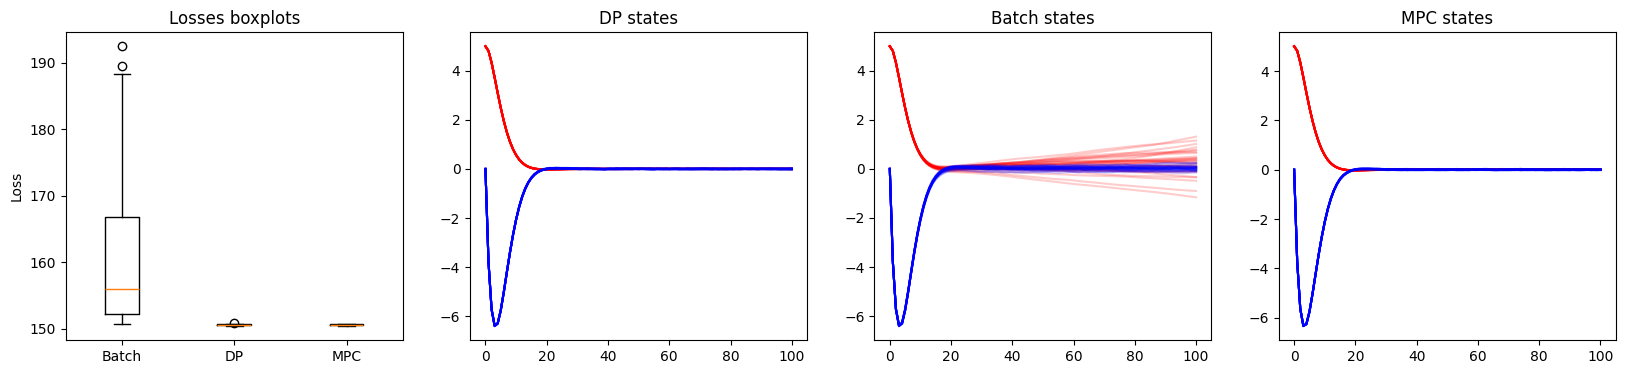

In [12]:
# prompt: compare the MPC with the recursive approach under disturbance, through different tests as done before

import matplotlib.pyplot as plt
import numpy as np
# ... (previous code)

# -----------------------------------------------------------------------------
# Compare MPC with other approaches under disturbance
# -----------------------------------------------------------------------------
n_tests = 30  # Number of tests
losses_mpc = np.zeros(n_tests)
xs_mpc = []

for k in range(n_tests):
    f_w = draw_f(T)
    x_mpc_w, u_mpc = mpc_control(A, B, Q, R, S, T, x0, prediction_horizon=10, f=f_w)


    # Recompute losses
    losses_mpc[k] = loss(x_mpc_w, u_mpc)
    xs_mpc.append(x_mpc_w)

# Boxplot of the losses
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
ax[0].boxplot([losses_batch, losses_dp, losses_mpc], tick_labels=['Batch', 'DP', 'MPC'])
ax[0].set_ylabel('Loss')
ax[0].set_title('Losses boxplots')

ax[1].plot(np.dstack(xs_dp)[0], label='DP', color='red', alpha=0.2)
ax[1].plot(np.dstack(xs_dp)[1], label='DP', color='blue', alpha=0.2)
ax[1].set_title('DP states')

ax[2].plot(np.dstack(xs_batch)[0], label='Batch', color='red', alpha=0.2)
ax[2].plot(np.dstack(xs_batch)[1], label='Batch', color='blue', alpha=0.2)
ax[2].set_title('Batch states')

ax[3].plot(np.dstack(xs_mpc)[0], label='MPC', color='red', alpha=0.2)
ax[3].plot(np.dstack(xs_mpc)[1], label='MPC', color='blue', alpha=0.2)
ax[3].set_title('MPC states');
